In [1]:
# Import required libraries and set plot style
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
# Load the original dataset
original_dataset = pd.read_csv('./Cu_alloys_database_2023_06_06.csv', encoding='utf-8', delimiter=';')

# Preprocessing

- Remove the DOI tag and alloy formula
- Convert alloy class to numerical format
- Convert Y/N questions into numerical format
- Drop duplicates

In [18]:
# Copy and preprocess the dataset
dataset = original_dataset.copy()
dataset.drop(columns=['DOI', 'Alloy formula'], inplace=True, errors='ignore')

alloy_classes = {
    'Cu low alloyed': 0,
    'Cu-Ni-Si alloys': 1,
    'Cu-Ti alloys': 2,
    'Cu-Be alloys': 3,
}

dataset['Alloy class'] = dataset['Alloy class'].apply(lambda x: alloy_classes[x] if x in alloy_classes else None)
dataset['Aging'] = dataset['Aging'].apply(lambda x: 1 if x == 'Y' else 0)
dataset['Secondary thermo-mechanical process'] = dataset['Secondary thermo-mechanical process'].apply(lambda x: 1 if x == 'Y' else 0)

# Drop columns not needed for this use case
dataset.drop(columns=['Ultimate tensile strength (MPa)', 'Yield strength (MPa)', 'Alloy class'], inplace=True, errors='ignore')
print("Before dropping rows with NaN values", dataset.shape)
dataset = dataset.dropna()
print("After dropping rows with NaN values", dataset.shape)

# Tss: temp of solid solutioning, tss: time of solid solutioning
# Tag: temp of ageing, tag: time of ageing

print(dataset.columns)

dataset.shape

Before dropping rows with NaN values (1831, 36)
After dropping rows with NaN values (1481, 36)
Index(['Cu', 'Al', 'Ag', 'B', 'Be', 'Ca', 'Co', 'Ce', 'Cr', 'Fe', 'Hf', 'La',
       'Mg', 'Mn', 'Mo', 'Nb', 'Nd', 'Ni', 'P', 'Pb', 'Pr', 'Si', 'Sn', 'Ti',
       'V', 'Zn', 'Zr', 'Tss (K)', 'tss (h)', 'CR reduction (%)', 'Aging',
       'Tag (K)', 'tag (h)', 'Secondary thermo-mechanical process',
       'Hardness (HV)', 'Electrical conductivity (%IACS)'],
      dtype='object')


(1481, 36)

# Problem Definition

Can we train a CVAE to perform the inverse design task of estimating the copper alloy composition and processing methods needed to achieve a certain electrical conductivity and hardness?

```
hardness, electrical conductivity --> CVAE Decoder --> process conditions, composition
```

In [19]:
# Split dataset into features (X) and targets (y)
X = dataset.drop(columns=['Hardness (HV)', 'Electrical conductivity (%IACS)', 'CR reduction (%)', 'Aging', 'Secondary thermo-mechanical process'])
y = dataset[['Hardness (HV)', 'Electrical conductivity (%IACS)']]


X

,Cu,Al,Ag,B,Be,Ca,Co,Ce,Cr,Fe,...,Si,Sn,Ti,V,Zn,Zr,Tss (K),tss (h),Tag (K),tag (h)
1,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,0.25
2,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,0.50
3,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,1.00
4,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,2.00
5,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,2.00
1821,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,3.00
1822,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,4.00
1823,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,8.00


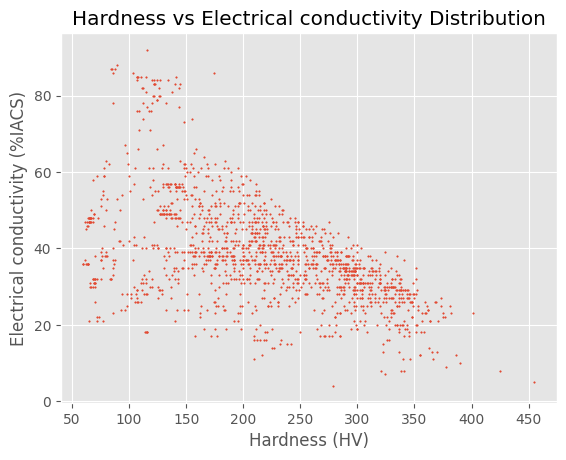

In [20]:
# Visualize the distribution of Hardness vs Electrical Conductivity
plt.scatter(dataset['Hardness (HV)'], dataset['Electrical conductivity (%IACS)'], s=1)
plt.xlabel('Hardness (HV)')
plt.ylabel('Electrical conductivity (%IACS)')
plt.title('Hardness vs Electrical conductivity Distribution')
plt.show()

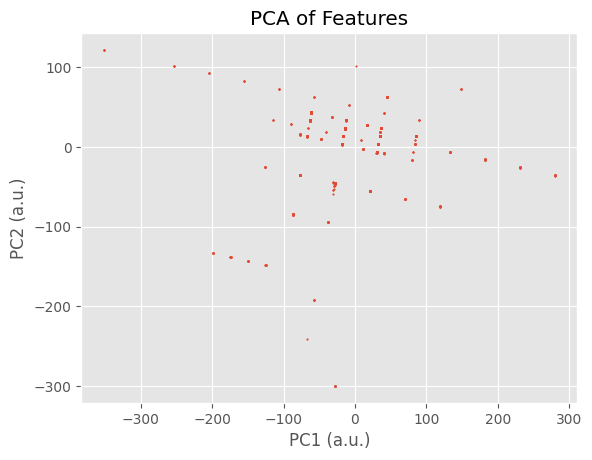

In [21]:
# PCA visualization of features
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.scatter(components[:, 0], components[:, 1], s=1)
plt.xlabel('PC1 (a.u.)')
plt.ylabel('PC2 (a.u.)')
plt.title('PCA of Features')
plt.show()

# Attempt 1: Traditional Neural Network

In [7]:
# Define and train a traditional neural network regressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RegressorNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128], output_dim=2):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

model_reg = RegressorNet(input_dim=X.shape[1], hidden_dims=[128, 256, 256, 128, 128, 64, 64, 32, 32]).to(device)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)
train_ds = TensorDataset(X_tensor, y_tensor)
test_ds = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)    
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model_reg.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer_reg.zero_grad()
        preds = model_reg(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_reg.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on test set
model_reg.eval()
with torch.no_grad():
    mse_sum = 0.0
    total_samples = 0
    for xb, yb in test_loader:
        preds = model_reg(xb)
        mse_sum += ((preds - yb) ** 2).sum().item()
        total_samples += yb.numel()
    mse = mse_sum / total_samples
    rmse = mse ** 0.5
    print("Test RMSE:", rmse)

Epoch 10/100, Loss: 3044.2747
Epoch 20/100, Loss: 2362.0861
Epoch 20/100, Loss: 2362.0861
Epoch 30/100, Loss: 1787.9802
Epoch 30/100, Loss: 1787.9802
Epoch 40/100, Loss: 1719.8519
Epoch 40/100, Loss: 1719.8519
Epoch 50/100, Loss: 1692.5388
Epoch 50/100, Loss: 1692.5388
Epoch 60/100, Loss: 1675.3204
Epoch 60/100, Loss: 1675.3204
Epoch 70/100, Loss: 1634.9601
Epoch 70/100, Loss: 1634.9601
Epoch 80/100, Loss: 1406.7303
Epoch 80/100, Loss: 1406.7303
Epoch 90/100, Loss: 1373.3020
Epoch 90/100, Loss: 1373.3020
Epoch 100/100, Loss: 1358.7372
Test RMSE: 36.352206005586666
Epoch 100/100, Loss: 1358.7372
Test RMSE: 36.352206005586666


# Attempt 2: CVAE + VampPrior

In [8]:
# Define CVAE and VampPrior models - MUCH BIGGER AND DEEPER
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[1]
cond_dim = y.shape[1]
latent_dim = 32  # Increased latent dimension significantly

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        
    def forward(self, x):
        return x + self.block(x)

class SelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        
    def forward(self, x):
        B, D = x.shape
        # Reshape for attention (treat each feature as a sequence element)
        x = x.unsqueeze(1)  # [B, 1, D]
        
        q = self.q_proj(x).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_weights, dim=-1)
        
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, 1, D)
        
        output = self.out_proj(attn_output).squeeze(1)
        return output + x.squeeze(1)  # Residual connection

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Much bigger and deeper encoder
        hidden_dims = [1024, 1024, 768, 768, 512, 512, 384, 256]
        
        # Initial projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim + cond_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Deep residual layers
        self.res_blocks = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.res_blocks.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.LayerNorm(hidden_dims[i+1]),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                ResidualBlock(hidden_dims[i+1]),
                ResidualBlock(hidden_dims[i+1])
            ))
        
        # Self-attention layers
        self.attention1 = SelfAttention(hidden_dims[-3])
        self.attention2 = SelfAttention(hidden_dims[-1])
        
        # Final layers for mean and logvar
        self.pre_final = nn.Sequential(
            nn.Linear(hidden_dims[-1], 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        
        self.fc_mean = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, latent_dim)
        )
        
        self.fc_logvar = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x, c):
        h = self.input_proj(torch.cat([x, c], dim=1))
        
        # Pass through residual blocks
        for i, block in enumerate(self.res_blocks):
            h = block(h)
            # Apply attention at specific layers
            if i == len(self.res_blocks) - 3:
                h = self.attention1(h)
            elif i == len(self.res_blocks) - 1:
                h = self.attention2(h)
        
        h = self.pre_final(h)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z, mean, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Much bigger and deeper decoder
        hidden_dims = [256, 384, 512, 512, 768, 768, 1024, 1024]
        
        # Initial projection
        self.input_proj = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # Deep residual layers
        self.res_blocks = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.res_blocks.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.LayerNorm(hidden_dims[i+1]),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                ResidualBlock(hidden_dims[i+1]),
                ResidualBlock(hidden_dims[i+1])
            ))
        
        # Self-attention layers
        self.attention1 = SelfAttention(hidden_dims[2])
        self.attention2 = SelfAttention(hidden_dims[-1])
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(hidden_dims[-1], 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim)
        )

    def forward(self, z, c):
        h = self.input_proj(torch.cat([z, c], dim=1))
        
        # Pass through residual blocks
        for i, block in enumerate(self.res_blocks):
            h = block(h)
            # Apply attention at specific layers
            if i == 2:
                h = self.attention1(h)
            elif i == len(self.res_blocks) - 1:
                h = self.attention2(h)
        
        return self.output_layers(h)

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x, c):
        z, mean, logvar = self.enc(x, c)
        x_recon = self.dec(z, c)
        return x_recon, mean, logvar

In [9]:
# Train/test/val split and data augmentation for CVAE
from sklearn.model_selection import train_test_split
import numpy as np

# Split into train / val / test
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)
X_train_np, X_val_np,  y_train_np, y_val_np  = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42
)

# Data augmentation: add small Gaussian noise to features in the training set
noise_level = 0.005
X_std = X_train_np.std(axis=0, keepdims=True)
noise = noise_level * X_std * np.random.randn(*X_train_np.shape)
X_aug = X_train_np + noise
X_train_np = np.vstack([X_train_np, X_aug])
y_train_np = np.vstack([y_train_np, y_train_np])

def make_loader(X_np, y_np, batch_size=64, shuffle=True):
    Xt = torch.from_numpy(X_np).float().to(device)
    yt = torch.from_numpy(y_np).float().to(device)
    ds = TensorDataset(Xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train_np, y_train_np)
val_loader   = make_loader(X_val_np,   y_val_np,   shuffle=False)
test_loader  = make_loader(X_test_np,  y_test_np,  shuffle=False)

# Model, optimizer, and training loop with early stopping
model   = CVAE().to(device)
opt     = optim.Adam(model.parameters())
epochs  = 300
patience = 20

best_val = float('inf')
wait = 0

beta = 0.1  # Adjust this value to balance reconstruction and regularization

from torch.optim.lr_scheduler import CyclicLR
scheduler = CyclicLR(opt, base_lr=1e-4, max_lr=1e-3, step_size_up=200, mode='triangular')

for epoch in range(1, epochs + 1):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        xr, mu, logvar = model(xb, yb)
        recon = nn.functional.mse_loss(xr, xb, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl
        loss.backward()
        opt.step()
        scheduler.step()

    # Compute train+val loss & RRMSE
    def eval_loader(loader):
        model.eval()
        mse_sum = 0.0
        true_sum = 0.0
        cnt = 0
        with torch.no_grad():
            for xb, yb in loader:
                xr, _, _ = model(xb, yb)
                diff = xr - xb
                mse_sum += float((diff**2).sum())
                true_sum += float(xb.sum())
                cnt += xb.numel()
        rmse  = np.sqrt(mse_sum / cnt)
        mean_true = true_sum / cnt
        return rmse / mean_true, mse_sum / cnt

    rrmse_tr, mse_tr = eval_loader(train_loader)
    rrmse_val, mse_val = eval_loader(val_loader)
    print(f"Epoch {epoch:03d}  train RRMSE={rrmse_tr:.4f}  val RRMSE={rrmse_val:.4f}")

    # Early stopping
    if mse_val < best_val:
        best_val = mse_val
        torch.save(model.state_dict(), 'best.pt')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# Load best model & final test evaluation
model.load_state_dict(torch.load('best.pt'))
rrmse_test, _ = eval_loader(test_loader)
print(f"Test RRMSE = {rrmse_test:.4f}")

Epoch 001  train RRMSE=3.8388  val RRMSE=3.8395
Epoch 002  train RRMSE=3.8334  val RRMSE=3.8342
Epoch 002  train RRMSE=3.8334  val RRMSE=3.8342
Epoch 003  train RRMSE=3.8248  val RRMSE=3.8256
Epoch 003  train RRMSE=3.8248  val RRMSE=3.8256
Epoch 004  train RRMSE=3.8121  val RRMSE=3.8128
Epoch 004  train RRMSE=3.8121  val RRMSE=3.8128
Epoch 005  train RRMSE=3.7942  val RRMSE=3.7949
Epoch 005  train RRMSE=3.7942  val RRMSE=3.7949
Epoch 006  train RRMSE=3.7699  val RRMSE=3.7706
Epoch 006  train RRMSE=3.7699  val RRMSE=3.7706
Epoch 007  train RRMSE=3.7382  val RRMSE=3.7388
Epoch 007  train RRMSE=3.7382  val RRMSE=3.7388
Epoch 008  train RRMSE=3.7052  val RRMSE=3.7058
Epoch 008  train RRMSE=3.7052  val RRMSE=3.7058
Epoch 009  train RRMSE=3.6750  val RRMSE=3.6756
Epoch 009  train RRMSE=3.6750  val RRMSE=3.6756
Epoch 010  train RRMSE=3.6490  val RRMSE=3.6495
Epoch 010  train RRMSE=3.6490  val RRMSE=3.6495
Epoch 011  train RRMSE=3.6281  val RRMSE=3.6286
Epoch 011  train RRMSE=3.6281  val RRMSE

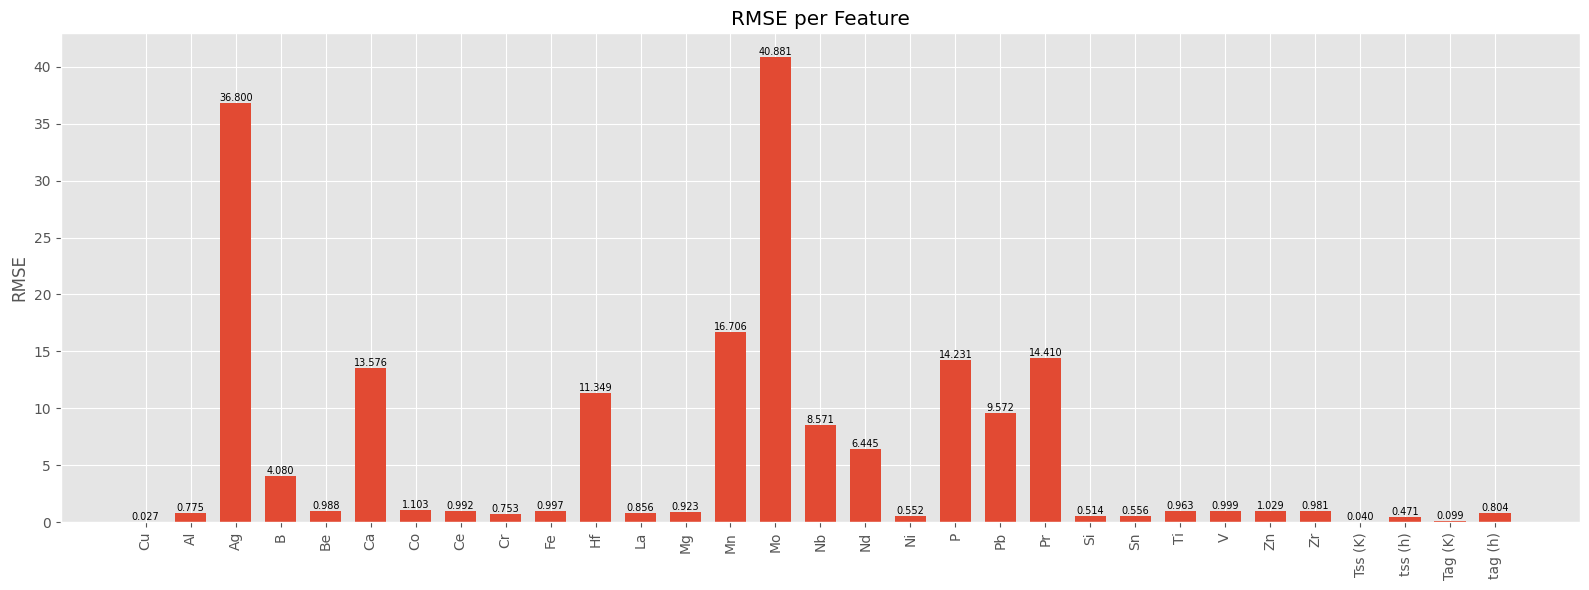

c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


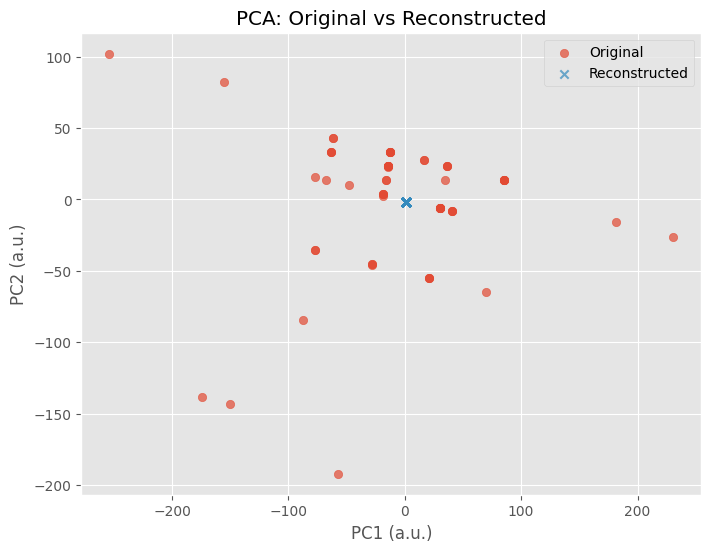

In [10]:
# Evaluate per-feature RMSE and visualize PCA of original vs reconstructed
# get one batch
xb_batch, yb_batch = next(iter(test_loader))
with torch.no_grad():
    xr_batch, _, _ = model(xb_batch, yb_batch)

xb_np = xb_batch.cpu().numpy()
xr_np = xr_batch.cpu().numpy()

# compute per‐feature relative RMSE
#    sqrt(mean((xr-xb)^2) / mean(xb^2))
# compute per‐feature relative RMSE with eps to avoid division by zero
den = np.mean(xb_np**2, axis=0)
den = np.where(den == 0, 1e-8, den)
rmse_feat = np.sqrt(np.mean((xr_np - xb_np)**2, axis=0) / den)

plt.figure(figsize=(16,6))
bars = plt.bar(X.columns, rmse_feat, width=0.7)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.title('RMSE per Feature')

# annotate each bar
for bar, val in zip(bars, rmse_feat):
    plt.text(bar.get_x() + bar.get_width()/2, val,
             f"{val:.3f}", ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

# PCA scatter of original vs reconstructed
# Fit PCA on the original data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the original and reconstructed data
orig_proj = pca.transform(xb_np)
rec_proj = pca.transform(xr_np)

# Plot PCA scatter of original vs reconstructed
plt.figure(figsize=(8, 6))
plt.scatter(orig_proj[:, 0], orig_proj[:, 1], label='Original', alpha=0.7)
plt.scatter(rec_proj[:, 0], rec_proj[:, 1], label='Reconstructed', alpha=0.7, marker='x')
plt.xlabel('PC1 (a.u.)')
plt.ylabel('PC2 (a.u.)')
plt.title('PCA: Original vs Reconstructed')
plt.legend()
plt.show()

Epoch 1/150, Train Loss: 0.0159, Val Loss: 0.0170
Epoch 2/150, Train Loss: 0.0159, Val Loss: 0.0170
Epoch 2/150, Train Loss: 0.0159, Val Loss: 0.0170
Epoch 3/150, Train Loss: 0.0159, Val Loss: 0.0172
Epoch 3/150, Train Loss: 0.0159, Val Loss: 0.0172
Epoch 4/150, Train Loss: 0.0160, Val Loss: 0.0166
Epoch 4/150, Train Loss: 0.0160, Val Loss: 0.0166
Epoch 5/150, Train Loss: 0.0158, Val Loss: 0.0170
Epoch 5/150, Train Loss: 0.0158, Val Loss: 0.0170
Epoch 6/150, Train Loss: 0.0158, Val Loss: 0.0169
Epoch 6/150, Train Loss: 0.0158, Val Loss: 0.0169
Epoch 7/150, Train Loss: 0.0160, Val Loss: 0.0165
Epoch 7/150, Train Loss: 0.0160, Val Loss: 0.0165
Epoch 8/150, Train Loss: 0.0158, Val Loss: 0.0168
Epoch 8/150, Train Loss: 0.0158, Val Loss: 0.0168
Epoch 9/150, Train Loss: 0.0159, Val Loss: 0.0167
Epoch 9/150, Train Loss: 0.0159, Val Loss: 0.0167
Epoch 10/150, Train Loss: 0.0159, Val Loss: 0.0169
Epoch 10/150, Train Loss: 0.0159, Val Loss: 0.0169
Epoch 11/150, Train Loss: 0.0158, Val Loss: 0.01

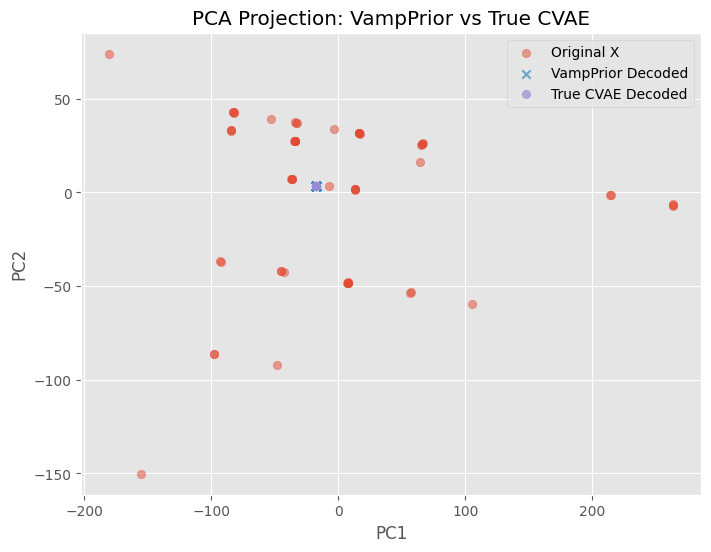

In [11]:
# Define and train VampPrior, evaluate and visualize
# ---- Implements a VampPrior: a mixture of variational posteriors on learned pseudo-inputs ----
class VampPrior(nn.Module):
    def __init__(self, num_pseudos=5):
        super().__init__()
        self.num_pseudos = num_pseudos
        # Pseudo-inputs split into x and c parts
        self.pseudos_x = nn.Parameter(torch.randn(num_pseudos, input_dim))
        self.pseudos_c = nn.Parameter(torch.randn(num_pseudos, cond_dim))

    def forward(self, batch_size):
        # Expand pseudos to batch
        # shapes: [B, K, input_dim], [B, K, cond_dim]
        px = self.pseudos_x.unsqueeze(0).expand(batch_size, -1, -1)
        pc = self.pseudos_c.unsqueeze(0).expand(batch_size, -1, -1)
        # Flatten to (B*K, dims)
        flat_x = px.reshape(batch_size * self.num_pseudos, input_dim)
        flat_c = pc.reshape(batch_size * self.num_pseudos, cond_dim)
        # Encode to get mixture component params
        _, mu, logvar = model.enc(flat_x, flat_c)
        # Reshape to [B, K, latent_dim]
        mu = mu.view(batch_size, self.num_pseudos, latent_dim)
        logvar = logvar.view(batch_size, self.num_pseudos, latent_dim)
        # Randomly select component per sample
        idx = torch.randint(0, self.num_pseudos, (batch_size,), device=mu.device)
        mu_sel = mu[torch.arange(batch_size), idx]
        lv_sel = logvar[torch.arange(batch_size), idx]
        eps = torch.randn_like(mu_sel)
        return mu_sel + eps * torch.exp(0.5 * lv_sel)

# Instantiate VampPrior
vamp_prior = VampPrior(num_pseudos=50).to(device)

# Train the VampPrior by aligning its output with the encoder’s posterior means
optimizer_vamp = optim.Adam(vamp_prior.parameters(), lr=1e-3)

epochs_vamp = 150

best_val_loss = float('inf')
patience = 10
trigger_count = 0

def eval_vamp_prior(loader):
    vamp_prior.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_size = xb.size(0)
            _, mu_true, _ = model.enc(xb, yb)
            pred_z = vamp_prior(batch_size)
            total_loss += criterion(pred_z, mu_true).item()
            total_count += batch_size
    return total_loss / total_count



for epoch in range(epochs_vamp):
    vamp_prior.train()
    total_loss = 0.0
    count = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_vamp.zero_grad()
        with torch.no_grad():
            _, mu_true, _ = model.enc(xb, yb)
        batch_size = xb.size(0)
        z_sample = vamp_prior(batch_size)
        loss = criterion(z_sample, mu_true)
        loss.backward()
        optimizer_vamp.step()
        total_loss += loss.item()
        count += batch_size
    
    train_loss = total_loss / count
    
    # Evaluate on test set (could also use a validation set if available)
    val_loss = eval_vamp_prior(test_loader)
    
    print(f"Epoch {epoch+1}/{epochs_vamp}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_count = 0
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping triggered.")
            break

# ---- Evaluation and Visualization ----
criterion = nn.MSELoss(reduction='sum')

# Evaluate latent-space MSE between VampPrior samples and encoder means
def eval_vamp_prior(loader):
    vamp_prior.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_size = xb.size(0)
            # True posterior means
            _, mu_true, _ = model.enc(xb, yb)
            # VampPrior samples
            pred_z = vamp_prior(batch_size)
            total_loss += criterion(pred_z, mu_true).item()
            total_count += batch_size
    return total_loss / total_count

print("Test Loss (VampPrior):", eval_vamp_prior(test_loader))

# Visual comparison via PCA
# Grab one batch
xb_b, yb_b = next(iter(train_loader))
xb_b, yb_b = xb_b.to(device), yb_b.to(device)
with torch.no_grad():
    # Samples
    z_vamp = vamp_prior(xb_b.size(0))
    x_dec_vamp = model.dec(z_vamp, yb_b)
    # True encoder means
    _, mu_true, _ = model.enc(xb_b, yb_b)
    x_dec_true = model.dec(mu_true, yb_b)

# Convert to numpy
orig_np = xb_b.cpu().numpy()
vamp_np = x_dec_vamp.cpu().numpy()
true_np = x_dec_true.cpu().numpy()

# PCA
pca = PCA(n_components=2)
pca.fit(orig_np)
proj_orig = pca.transform(orig_np)
proj_vamp = pca.transform(vamp_np)
proj_true = pca.transform(true_np)

plt.figure(figsize=(8, 6))
plt.scatter(proj_orig[:, 0], proj_orig[:, 1], label='Original X', alpha=0.5)
plt.scatter(proj_vamp[:, 0], proj_vamp[:, 1], label='VampPrior Decoded', alpha=0.7, marker='x')
plt.scatter(proj_true[:, 0], proj_true[:, 1], label='True CVAE Decoded', alpha=0.7, marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection: VampPrior vs True CVAE')
plt.legend()
plt.show()

# Attempt 3: Adversarial Latent Autoencoder

In [12]:
# Define ALAE (Adversarial Latent Autoencoder) and its training setup
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Encoder: encodes [X, y] to latent z.
class EncoderALAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    def forward(self, x, c):
        x_cat = torch.cat([x, c], dim=1)
        z = self.fc(x_cat)
        return z

# Decoder: reconstructs X from [z, y].
class DecoderALAE(nn.Module):
    def __init__(self, latent_dim, cond_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z, c):
        z_cat = torch.cat([z, c], dim=1)
        x_recon = self.fc(z_cat)
        return x_recon

# Discriminator: distinguishes between samples from the prior and those from the encoder.
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

# Hyperparameters
input_dim = X.shape[1]
cond_dim = y.shape[1]
latent_dim = 8
adv_weight = 1000 # weight for the adversarial loss in the autoencoder objective
lr = 1e-3
epochs_aae = 200
batch_size = 64

# Create a dataset and loader (using values from X and y)
dataset_aae = TensorDataset(
    torch.tensor(X.values, dtype=torch.float32).to(device),
    torch.tensor(y.values, dtype=torch.float32).to(device)
)
train_loader_aae = DataLoader(dataset_aae, batch_size=batch_size, shuffle=True)

# Instantiate networks
encoder_aae = EncoderALAE(input_dim, cond_dim, latent_dim).to(device)
decoder_aae = DecoderALAE(latent_dim, cond_dim, input_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

# Optimizers for autoencoder and discriminator
optimizer_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

In [13]:
# Train ALAE with early stopping and validation
from torch.utils.data import random_split

# Increase epochs and set early stopping parameters.
epochs_aae = 500
patience = 25
best_val_loss = float('inf')
patience_counter = 0

# Split dataset into training and validation (80/20 split).
train_size = int(0.8 * len(dataset_aae))
val_size = len(dataset_aae) - train_size
train_dataset, val_dataset = random_split(dataset_aae, [train_size, val_size])
train_loader_aae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_aae = DataLoader(val_dataset, batch_size=batch_size)

for epoch in range(epochs_aae):
    encoder_aae.train()
    decoder_aae.train()
    discriminator.train()
    
    total_recon_loss = 0.0
    total_adv_loss = 0.0
    total_disc_loss = 0.0
    
    for xb, yb in train_loader_aae:
        cur_bs = xb.size(0)
        
        # --- Train Discriminator ---
        optimizer_disc.zero_grad()
        z_prior = torch.randn(cur_bs, latent_dim, device=device)
        z_enc = encoder_aae(xb, yb).detach()
        d_real = discriminator(z_prior)
        d_fake = discriminator(z_enc)
        
        real_labels = torch.ones(cur_bs, 1, device=device)
        fake_labels = torch.zeros(cur_bs, 1, device=device)
        
        loss_d_real = bce_loss(d_real, real_labels)
        loss_d_fake = bce_loss(d_fake, fake_labels)
        loss_disc = (loss_d_real + loss_d_fake) / 2
        
        loss_disc.backward()
        optimizer_disc.step()
        
        # --- Train Autoencoder (Encoder + Decoder) ---
        optimizer_ae.zero_grad()
        z_enc = encoder_aae(xb, yb)
        x_recon = decoder_aae(z_enc, yb)
        recon_loss = mse_loss(x_recon, xb)
        
        d_fake_for_adv = discriminator(z_enc)
        adv_loss = bce_loss(d_fake_for_adv, real_labels)
        
        loss_ae = recon_loss + adv_weight * adv_loss
        loss_ae.backward()
        optimizer_ae.step()
        
        total_recon_loss += recon_loss.item() * cur_bs
        total_adv_loss += adv_loss.item() * cur_bs
        total_disc_loss += loss_disc.item() * cur_bs

    total_samples = len(train_dataset)
    train_recon = total_recon_loss / total_samples
    train_adv = total_adv_loss / total_samples
    train_disc = total_disc_loss / total_samples
    
    # --- Evaluate on validation set ---
    encoder_aae.eval()
    decoder_aae.eval()
    
    val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader_aae:
            cur_bs_val = xb_val.size(0)
            z_enc_val = encoder_aae(xb_val, yb_val)
            x_recon_val = decoder_aae(z_enc_val, yb_val)
            loss_val = mse_loss(x_recon_val, xb_val)
            val_loss += loss_val.item() * cur_bs_val
    val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{epochs_aae}], Train Recon: {train_recon:.4f}, "
          f"Train Adv: {train_adv:.4f}, Train Disc: {train_disc:.4f}, Val Recon: {val_loss:.4f}")
    
    # Early stopping check (using validation reconstruction loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(encoder_aae.state_dict(), 'best_encoder.pt')
        torch.save(decoder_aae.state_dict(), 'best_decoder.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/500], Train Recon: 56470.9774, Train Adv: 3.5822, Train Disc: 0.6505, Val Recon: 39653.3725
Epoch [2/500], Train Recon: 14742.4977, Train Adv: 9.8626, Train Disc: 0.4519, Val Recon: 2917.0030
Epoch [3/500], Train Recon: 1713.1035, Train Adv: 9.3829, Train Disc: 0.4389, Val Recon: 907.3914
Epoch [2/500], Train Recon: 14742.4977, Train Adv: 9.8626, Train Disc: 0.4519, Val Recon: 2917.0030
Epoch [3/500], Train Recon: 1713.1035, Train Adv: 9.3829, Train Disc: 0.4389, Val Recon: 907.3914
Epoch [4/500], Train Recon: 874.0371, Train Adv: 6.8663, Train Disc: 0.3877, Val Recon: 692.4423
Epoch [4/500], Train Recon: 874.0371, Train Adv: 6.8663, Train Disc: 0.3877, Val Recon: 692.4423
Epoch [5/500], Train Recon: 546.5339, Train Adv: 6.8562, Train Disc: 0.3354, Val Recon: 564.8014
Epoch [6/500], Train Recon: 572.1011, Train Adv: 7.1804, Train Disc: 0.2849, Val Recon: 723.6670
Epoch [5/500], Train Recon: 546.5339, Train Adv: 6.8562, Train Disc: 0.3354, Val Recon: 564.8014
Epoch [6/500], Tra

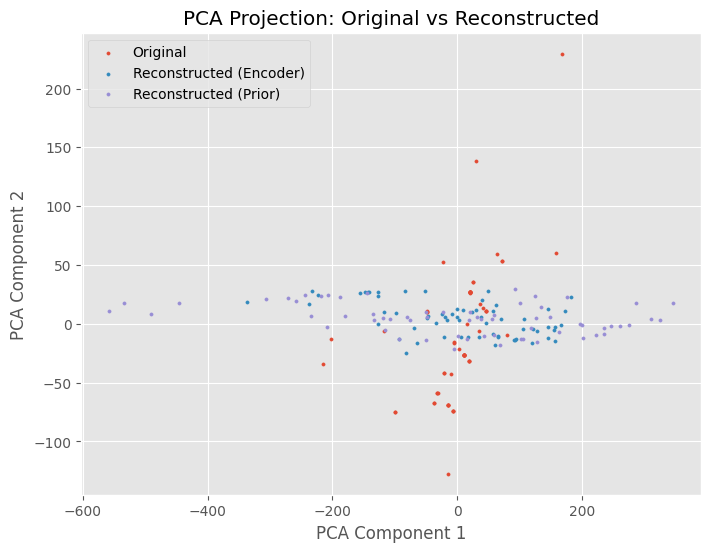

In [14]:
# Evaluate ALAE reconstruction and visualize with PCA
# Evaluate reconstruction on one batch (for example purposes)
encoder_aae.eval()
decoder_aae.eval()
with torch.no_grad():
    xb_test, yb_test = next(iter(train_loader_aae))
    
    # Reconstruction from encoded samples
    x_recon_test = decoder_aae(encoder_aae(xb_test, yb_test), yb_test)
    
    # Reconstruction from a predetermined prior (sample z from N(0,1))
    z_prior_sample = torch.randn(xb_test.size(0), latent_dim, device=device)
    x_recon_from_prior = decoder_aae(z_prior_sample, yb_test)

    # Combine original, encoder-based and prior-based reconstructions for PCA visualization
    combined = torch.cat([xb_test, x_recon_test, x_recon_from_prior], dim=0).cpu().numpy()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined)

    n = xb_test.shape[0]
    orig_transformed = pca_result[:n, :]
    enc_transformed = pca_result[n:2*n, :]
    prior_transformed = pca_result[2*n:3*n, :]

    plt.figure(figsize=(8,6))
    plt.scatter(orig_transformed[:, 0], orig_transformed[:, 1], s=5, label="Original")
    plt.scatter(enc_transformed[:, 0], enc_transformed[:, 1], s=5, label="Reconstructed (Encoder)")
    plt.scatter(prior_transformed[:, 0], prior_transformed[:, 1], s=5, label="Reconstructed (Prior)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Projection: Original vs Reconstructed")
    plt.legend()
    plt.show()

# Attempt 3.1: Hyperparameter Optimization for Adversarial Loss Weighting

In [15]:
# Hyperparameter optimization for adversarial loss weight (alpha tuning)
# Attempt 3.1: Hyperparameter Optimization for Adv. Loss Weight (alpha tuning)
alpha_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
results = []

for alpha in alpha_list:
    # reinitialize weights
    for net in (encoder_aae, decoder_aae, discriminator):
        net.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    adv_weight = alpha
    opt_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr)
    # short training loop
    for _ in range(50):
        for xb, yb in train_loader_aae:
            # train discriminator
            opt_disc.zero_grad()
            z_p = torch.randn(xb.size(0), latent_dim, device=device)
            z_e = encoder_aae(xb, yb).detach()
            d_loss = 0.5*(bce_loss(discriminator(z_p), torch.ones(xb.size(0),1,device=device))
                          + bce_loss(discriminator(z_e), torch.zeros(xb.size(0),1,device=device)))
            d_loss.backward(); opt_disc.step()
            # train autoencoder
            opt_ae.zero_grad()
            z_e2 = encoder_aae(xb, yb)
            recon = mse_loss(decoder_aae(z_e2, yb), xb)
            adv  = bce_loss(discriminator(z_e2), torch.ones(xb.size(0),1,device=device))
            (recon + adv_weight*adv).backward(); opt_ae.step()
    # evaluate prior‐reconstruction error on validation set
    encoder_aae.eval(); decoder_aae.eval()
    errs = []
    with torch.no_grad():
        for xb_val, yb_val in val_loader_aae:
            zp = torch.randn(xb_val.size(0), latent_dim, device=device)
            rec_p = decoder_aae(zp, yb_val)
            errs.append(mse_loss(rec_p, xb_val).item())
    results.append((alpha, sum(errs)/len(errs)))

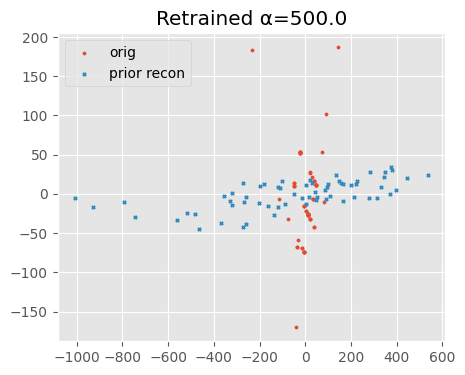

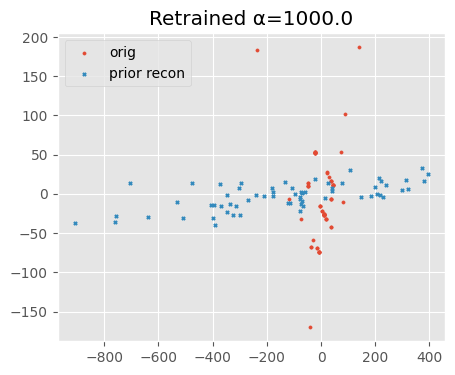

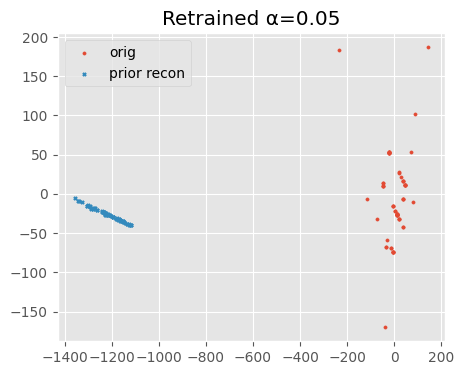

In [16]:
# Retrain ALAE with best alphas and visualize
# select top‐3 alphas
best = sorted(results, key=lambda x: x[1])[:3]
best_alphas = [a for a,_ in best]

# retrain with a full loop for each of the best alphas, then visualize
for a in best_alphas:
    # re-init
    for net in (encoder_aae, decoder_aae, discriminator):
        net.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)

    adv_weight = a
    opt_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # full training loop (example: 100 epochs)
    for epoch in range(200):
        encoder_aae.train()
        decoder_aae.train()
        discriminator.train()
        for xb, yb in train_loader_aae:            # train discriminator
            opt_disc.zero_grad()
            z_p = torch.randn(xb.size(0), latent_dim, device=device)
            z_e = encoder_aae(xb, yb).detach()
            loss_d = 0.5 * (
                bce_loss(discriminator(z_p), torch.ones(xb.size(0),1,device=device))
                + bce_loss(discriminator(z_e), torch.zeros(xb.size(0),1,device=device))
            )
            loss_d.backward()
            opt_disc.step()

            # train autoencoder
            opt_ae.zero_grad()
            z_e2 = encoder_aae(xb, yb)
            loss_recon = mse_loss(decoder_aae(z_e2, yb), xb)
            loss_adv = bce_loss(discriminator(z_e2), torch.ones(xb.size(0),1,device=device))
            (loss_recon + adv_weight * loss_adv).backward()
            opt_ae.step()

    # visualization
    encoder_aae.eval()
    decoder_aae.eval()
    xb, yb = next(iter(val_loader_aae))
    with torch.no_grad():
        zp = torch.randn(xb.size(0), latent_dim, device=device)
        xr = decoder_aae(zp, yb)
    orig_proj  = pca.transform(xb.cpu().numpy())
    recon_proj = pca.transform(xr.cpu().numpy())
    plt.figure(figsize=(5,4))
    plt.scatter(orig_proj[:,0],  orig_proj[:,1],  s=5, label='orig')
    plt.scatter(recon_proj[:,0], recon_proj[:,1], s=5, label='prior recon', marker='x')
    plt.title(f"Retrained α={a}")
    plt.legend()
    plt.show()

# Attempt 4: Conditional TABULAR Generative Adversarial Network

In [17]:
# Define and train CTGAN (Conditional Tabular GAN)
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import trange

import torch.nn.utils as utils

class GeneratorCTGAN(nn.Module):
    def __init__(self, noise_dim, cond_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
        )
    def forward(self, z, c):
        return self.net(torch.cat([z, c], dim=1))

class DiscriminatorCTGAN(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            utils.spectral_norm(nn.Linear(input_dim + cond_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            utils.spectral_norm(nn.Linear(hidden_dim // 2, 1)),
            # No sigmoid here!
        )
    def forward(self, x, c):
        return self.net(torch.cat([x, c], dim=1))

# Hyperparameters
noise_dim = 8
hidden_dim = 512
batch_size = 128
epochs_ctgan = 5000
lr = 5e-4
beta1, beta2 = 0.5, 0.9

# Instantiate Generator and Discriminator
generator = GeneratorCTGAN(noise_dim=noise_dim, cond_dim=cond_dim, output_dim=input_dim, hidden_dim=hidden_dim).to(device)
discriminator = DiscriminatorCTGAN(input_dim=input_dim, cond_dim=cond_dim, hidden_dim=hidden_dim).to(device)

# Optimizers
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Loss function (no sigmoid in D, so use BCEWithLogitsLoss)
bce_logits = nn.BCEWithLogitsLoss()

# Label smoothing
real_label = 0.9
fake_label = 0.1

# Gradient penalty for WGAN-GP style regularization
def gradient_penalty(discriminator, real_data, fake_data, cond):
    alpha = torch.rand(real_data.size(0), 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates, cond)
    grad_outputs = torch.ones_like(d_interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(real_data.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# Training loop
lambda_gp = 10.0
for epoch in range(epochs_ctgan):
    generator.train()
    discriminator.train()
    
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_gp = 0.0
    
    for xb, yb in train_loader_aae:
        cur_bs = xb.size(0)
        
        # --- Train Discriminator ---
        opt_disc.zero_grad()
        
        # Real samples
        real_targets = torch.full((cur_bs, 1), real_label, device=device)
        fake_targets = torch.full((cur_bs, 1), fake_label, device=device)
        d_real = discriminator(xb, yb)
        loss_real = bce_logits(d_real, real_targets)
        
        # Fake samples
        z_noise = torch.randn(cur_bs, noise_dim, device=device)
        x_fake = generator(z_noise, yb)
        d_fake = discriminator(x_fake.detach(), yb)
        loss_fake = bce_logits(d_fake, fake_targets)
        
        # Gradient penalty
        gp = gradient_penalty(discriminator, xb, x_fake.detach(), yb)
        total_gp += gp.item() * cur_bs
        
        # Total discriminator loss
        loss_disc = loss_real + loss_fake + lambda_gp * gp
        loss_disc.backward()
        opt_disc.step()
        
        # --- Train Generator ---
        opt_gen.zero_grad()
        z_noise2 = torch.randn(cur_bs, noise_dim, device=device)
        x_fake2 = generator(z_noise2, yb)
        d_fake2 = discriminator(x_fake2, yb)
        # Use softplus for generator loss for stability
        loss_gen = nn.functional.softplus(-d_fake2).mean()
        loss_gen.backward()
        opt_gen.step()
        
        total_gen_loss += loss_gen.item() * cur_bs
        total_disc_loss += loss_disc.item() * cur_bs
    
    total_samples = len(train_loader_aae.dataset)
    avg_gen_loss = total_gen_loss / total_samples
    avg_disc_loss = total_disc_loss / total_samples
    avg_gp = total_gp / total_samples
    
    print(f"Epoch [{epoch+1}/{epochs_ctgan}], Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, GP: {avg_gp:.4f}")


    if epoch % 50 == 0:
        torch.save(generator.state_dict(), f'ctgan/generator_epoch_{epoch}.pt')
        torch.save(discriminator.state_dict(), f'ctgan/discriminator_epoch_{epoch}.pt')

Epoch [1/5000], Gen Loss: 4.0927, Disc Loss: 12.8426, GP: 0.7863
Epoch [2/5000], Gen Loss: 4.0470, Disc Loss: 9.5483, GP: 0.6175
Epoch [2/5000], Gen Loss: 4.0470, Disc Loss: 9.5483, GP: 0.6175
Epoch [3/5000], Gen Loss: 3.7165, Disc Loss: 7.5673, GP: 0.5309
Epoch [3/5000], Gen Loss: 3.7165, Disc Loss: 7.5673, GP: 0.5309
Epoch [4/5000], Gen Loss: 4.2134, Disc Loss: 6.9600, GP: 0.5002
Epoch [4/5000], Gen Loss: 4.2134, Disc Loss: 6.9600, GP: 0.5002
Epoch [5/5000], Gen Loss: 4.0393, Disc Loss: 7.8402, GP: 0.5573
Epoch [5/5000], Gen Loss: 4.0393, Disc Loss: 7.8402, GP: 0.5573
Epoch [6/5000], Gen Loss: 4.1952, Disc Loss: 7.5133, GP: 0.5964
Epoch [6/5000], Gen Loss: 4.1952, Disc Loss: 7.5133, GP: 0.5964
Epoch [7/5000], Gen Loss: 4.4551, Disc Loss: 7.7949, GP: 0.6127
Epoch [7/5000], Gen Loss: 4.4551, Disc Loss: 7.7949, GP: 0.6127
Epoch [8/5000], Gen Loss: 4.5527, Disc Loss: 7.9484, GP: 0.6219
Epoch [8/5000], Gen Loss: 4.5527, Disc Loss: 7.9484, GP: 0.6219
Epoch [9/5000], Gen Loss: 4.9701, Disc 

KeyboardInterrupt: 

In [ ]:
# Visualize CTGAN synthetic data evolution with PCA animation
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Directory containing generator checkpoints
checkpoint_dir = "ctgan"
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("generator") and f.endswith(".pt")])

# Prepare real data PCA
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X.values)

# Store PCA results for each checkpoint
synthetic_pca_list = []

# Generate synthetic data for each checkpoint
for checkpoint in checkpoints:
    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, checkpoint)))
    generator.eval()
    with torch.no_grad():
        z_noise = torch.randn(X.shape[0], noise_dim, device=device)
        synthetic_data = generator(z_noise, torch.tensor(y.values, dtype=torch.float32).to(device)).cpu().numpy()
        synthetic_pca = pca.transform(synthetic_data)
        synthetic_pca_list.append(synthetic_pca)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the scatter plots
real_scatter = ax.scatter(real_pca[:, 0], real_pca[:, 1], label='Real Data', alpha=0.7, s=10)
synthetic_scatter = ax.scatter([], [], label='Synthetic Data', alpha=0.3, s=10, marker='x')

# Set up the plot
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('CTGAN: Real vs Synthetic Data Over Time')
ax.legend()

# Update function for the animation
def update(frame):
    synthetic_scatter.set_offsets(synthetic_pca_list[frame])
    ax.set_title(f'CTGAN: Real vs Synthetic Data (Checkpoint {frame + 1})')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(synthetic_pca_list), interval=500)

# Save the animation as a video or display it
ani.save('ctgan_pca_evolution.mp4', writer='ffmpeg', fps=2)
plt.show()

# Verification Network

In [ ]:
# Plot Hardness (HV) and compute the median threshold
plt.plot((y['Hardness (HV)']))

# Compute the median hardness as a 50/50 threshold
median_threshold = y['Hardness (HV)'].median()
print(f"50/50 threshold for Hardness (HV): {median_threshold}")

# Plot threshold line
plt.axhline(median_threshold, color='red', linestyle='--', label=f"median={median_threshold:.1f}")
plt.legend()
plt.show()

In [ ]:
# Define and train the HardnessClassifier neural network
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

class HardnessClassifier(nn.Module):
    def __init__(self, input_dim):
        super(HardnessClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Prepare the data for binary classification
y_binary = (y['Hardness (HV)'] > median_threshold).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X.values, y_binary.values, test_size=0.05, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hardness_classifier = HardnessClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(hardness_classifier.parameters(), lr=1e-3)

# Training loop with early stopping
epochs = 300
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    hardness_classifier.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = hardness_classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    hardness_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            preds = hardness_classifier(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(hardness_classifier.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
hardness_classifier.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
hardness_classifier.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = hardness_classifier(xb).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend((preds > 0.5).astype(int))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

In [ ]:
import matplotlib.pyplot as plt

hardness_targets = np.linspace(np.min(y['Hardness (HV)']), np.max(y['Hardness (HV)']), 100)
num_samples = 1000
conductivity_mean = np.mean(y['Electrical conductivity (%IACS)'])
conductivity_std = np.std(y['Electrical conductivity (%IACS)'])

# Initialize lists to store accuracies for each model
hardness_values = []
accuracy_alae = []
accuracy_cvae = []
accuracy_ctgan = []

print("Testing synthetic generation and classification for above/below median hardness")

for target in hardness_targets:
    # Determine the expected label (1 if above threshold, 0 if below)
    expected_label = 1 if target > median_threshold else 0
    expected_labels = np.full(num_samples, expected_label)

    # Generate conditional input: fixed hardness, random conductivity
    cond_np = np.column_stack([
        np.full(num_samples, target),
        np.random.normal(conductivity_mean, conductivity_std, num_samples)
    ])
    cond = torch.tensor(cond_np, dtype=torch.float32).to(device)

    # Sample latent vectors from standard normal for generative models
    z_prior = torch.randn(num_samples, latent_dim, device=device)

    print(f"\n--- Hardness target = {target:.1f} (Expected label={expected_label}) ---")

    # --- ALAE (Adversarial Latent Autoencoder) ---
    syn_X_alae = decoder_aae(z_prior, cond)
    hardness_classifier.eval()
    with torch.no_grad():
        alaepreds = (hardness_classifier(syn_X_alae) > 0.5).int().cpu().numpy().flatten()
    n_positive_alae = alaepreds.sum()
    acc_alae = accuracy_score(expected_labels, alaepreds)
    diff_alae = n_positive_alae - (num_samples if expected_label == 1 else 0)
    print(f"ALAE: {n_positive_alae}/{num_samples} predicted above threshold "
          f"({'+' if diff_alae > 0 else ''}{diff_alae}) | Accuracy: {acc_alae:.3f}")

    # --- CVAE (Conditional Variational Autoencoder) ---
    syn_X_cvae = model.dec(z_prior, cond)
    with torch.no_grad():
        cvaepreds = (hardness_classifier(syn_X_cvae) > 0.5).int().cpu().numpy().flatten()
    n_positive_cvae = cvaepreds.sum()
    acc_cvae = accuracy_score(expected_labels, cvaepreds)
    diff_cvae = n_positive_cvae - (num_samples if expected_label == 1 else 0)
    print(f"CVAE: {n_positive_cvae}/{num_samples} predicted above threshold "
          f"({'+' if diff_cvae > 0 else ''}{diff_cvae}) | Accuracy: {acc_cvae:.3f}")

    # --- CTGAN (Conditional Tabular GAN) ---
    z_ctgan = torch.randn(num_samples, noise_dim, device=device)
    syn_X_ctgan = generator(z_ctgan, cond)
    with torch.no_grad():
        ctganpreds = (hardness_classifier(syn_X_ctgan) > 0.5).int().cpu().numpy().flatten()
    n_positive_ctgan = ctganpreds.sum()
    acc_ctgan = accuracy_score(expected_labels, ctganpreds)
    diff_ctgan = n_positive_ctgan - (num_samples if expected_label == 1 else 0)
    print(f"CTGAN: {n_positive_ctgan}/{num_samples} predicted above threshold "
          f"({'+' if diff_ctgan > 0 else ''}{diff_ctgan}) | Accuracy: {acc_ctgan:.3f}")

    # Store results for visualization
    hardness_values.append(target)
    accuracy_alae.append(acc_alae)
    accuracy_cvae.append(acc_cvae)
    accuracy_ctgan.append(acc_ctgan)

# Visualization of accuracy as a function of hardness target
plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

# Add a secondary y-axis for the histogram
ax1.hist(y['Hardness (HV)'], bins=30, color='gray', density=True, alpha=0.4)
ax1.set_ylabel('Density', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot accuracy curves
ax2.plot(hardness_values, accuracy_alae, label='ALAE', marker='o')
ax2.plot(hardness_values, accuracy_cvae, label='CVAE', marker='s')
ax2.plot(hardness_values, accuracy_ctgan, label='CTGAN', marker='^')

# Overlay histogram for hardness target distribution
#plt.hist(y['Hardness (HV)'], bins=30, alpha=0.3, color='gray', label='Hardness Distribution', density=True)

# Add median threshold line
plt.axvline(median_threshold, color='red', linestyle='--', label='Median Threshold')

# Labels, title, and legend
plt.xlabel('Hardness Target')
plt.ylabel('Accuracy / Density')
plt.title('Accuracy of Generative Models as a Function of Hardness Target')
plt.legend()
plt.grid()
plt.show()


# Attempt 5: Tree-like Encoder CVAE

Tree-based architectures can capture complex feature interactions through hierarchical branching structures. We'll implement a tree-like encoder that processes features through multiple branching paths before merging them.

In [36]:
# Define Tree-like Encoder CVAE with improvements
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class TreeNode(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth=0, max_depth=3):
        super().__init__()
        self.depth = depth
        self.max_depth = max_depth
        self.is_leaf = depth >= max_depth
        
        if self.is_leaf:
            # Leaf node - simple linear transformation
            self.transform = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.LeakyReLU(0.2),  # Changed to LeakyReLU
                nn.Dropout(0.1)     # Reduced dropout
            )
        else:
            # Branch node - split into left and right subtrees
            split_dim = input_dim // 2
            self.left_child = TreeNode(split_dim, hidden_dim, depth + 1, max_depth)
            self.right_child = TreeNode(input_dim - split_dim, hidden_dim, depth + 1, max_depth)
            
            # Merge operation for combining left and right outputs
            self.merge = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.1)
            )
    
    def forward(self, x):
        if self.is_leaf:
            return self.transform(x)
        else:
            # Split input for left and right branches
            split_point = x.shape[1] // 2
            left_input = x[:, :split_point]
            right_input = x[:, split_point:]
            
            left_output = self.left_child(left_input)
            right_output = self.right_child(right_input)
            
            # Merge outputs
            merged = torch.cat([left_output, right_output], dim=1)
            return self.merge(merged)

class TreeEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial feature processing
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)  # Reduced dropout
        )
        
        # Tree-like processing with multiple branches
        self.tree1 = TreeNode(512, 256, max_depth=3)
        self.tree2 = TreeNode(512, 256, max_depth=2)
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Linear(256 * 2, 384),
            nn.LayerNorm(384),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        # Parallel processing paths
        self.path1 = nn.Sequential(
            nn.Linear(384, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128)
        )
        
        self.path2 = nn.Sequential(
            nn.Linear(384, 192),
            nn.LeakyReLU(0.2),
            nn.Linear(192, 128)
        )
        
        # Final encoding layers
        self.pre_latent = nn.Sequential(
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
    
    def forward(self, x, c):
        # Initial projection
        h = self.input_proj(torch.cat([x, c], dim=1))
        
        # Tree processing
        tree1_out = self.tree1(h)
        tree2_out = self.tree2(h)
        
        # Fusion
        fused = self.fusion(torch.cat([tree1_out, tree2_out], dim=1))
        
        # Parallel paths
        path1_out = self.path1(fused)
        path2_out = self.path2(fused)
        
        # Combine paths
        combined = torch.cat([path1_out, path2_out], dim=1)
        h_final = self.pre_latent(combined)
        
        # Generate latent parameters with constraints
        mean = self.fc_mean(h_final)
        logvar = self.fc_logvar(h_final)
        
        # Clamp logvar to prevent collapse
        logvar = torch.clamp(logvar, min=-10, max=2)
        
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        
        return z, mean, logvar

class TreeDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial projection
        self.input_proj = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        # Multi-scale processing
        self.scale1 = nn.Sequential(
            nn.Linear(256, 384),
            nn.LayerNorm(384),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        self.scale2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        )
        
        # Tree-like expansion
        self.expand_tree = TreeNode(896, 512, max_depth=2)
        
        # Final reconstruction layers with skip connection
        self.reconstruction = nn.Sequential(
            nn.Linear(512, 384),
            nn.LayerNorm(384),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(384, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, z, c):
        # Initial processing
        h = self.input_proj(torch.cat([z, c], dim=1))
        
        # Multi-scale processing
        scale1_out = self.scale1(h)
        scale2_out = self.scale2(h)
        
        # Combine scales
        combined = torch.cat([scale1_out, scale2_out], dim=1)
        
        # Tree expansion
        expanded = self.expand_tree(combined)
        
        # Final reconstruction
        return self.reconstruction(expanded)

class TreeCVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = TreeEncoder()
        self.dec = TreeDecoder()
    
    def forward(self, x, c):
        z, mean, logvar = self.enc(x, c)
        x_recon = self.dec(z, c)
        return x_recon, mean, logvar

# Initialize and train the Tree CVAE with improved settings
print("Initializing Tree CVAE...")
tree_model = TreeCVAE().to(device)
tree_opt = optim.Adam(tree_model.parameters(), lr=1e-2, weight_decay=1e-6)  # Lower learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(tree_opt, patience=10, factor=0.8)

# Training parameters - modified for better convergence
tree_epochs = 300
tree_patience = 25
tree_best_val = float('inf')
tree_wait = 0

# Beta scheduling for KL annealing
def get_beta(epoch, max_epochs=100):
    return min(1.0, epoch / max_epochs) * 0.5  # Gradual increase, lower max value

tree_recon_weight = 1.0  # Increased reconstruction weight

print(f"Training Tree CVAE for {tree_epochs} epochs...")

for epoch in range(1, tree_epochs + 1):
    tree_model.train()
    epoch_loss = 0
    tree_beta = get_beta(epoch)  # Dynamic beta
    
    for xb, yb in train_loader:
        tree_opt.zero_grad()
        xr, mu, logvar = tree_model(xb, yb)
        
        # Reconstruction loss
        recon = nn.functional.mse_loss(xr, xb, reduction='sum')
        
        # KL divergence with free bits
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Free bits - only penalize KL if it's above threshold
        free_bits = 0.1 * latent_dim  # Small threshold per dimension
        kl = torch.clamp(kl - free_bits, min=0)
        
        loss = tree_recon_weight * recon + tree_beta * kl
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(tree_model.parameters(), max_norm=1.0)
        
        tree_opt.step()
        epoch_loss += loss.item()
    
    # Evaluation
    def eval_tree_loader(loader):
        tree_model.eval()
        mse_sum = 0.0
        true_sum = 0.0
        cnt = 0
        with torch.no_grad():
            for xb, yb in loader:
                xr, _, _ = tree_model(xb, yb)
                diff = xr - xb
                mse_sum += float((diff**2).sum())
                true_sum += float(xb.sum())
                cnt += xb.numel()
        rmse = np.sqrt(mse_sum / cnt)
        mean_true = true_sum / cnt
        return rmse / mean_true, mse_sum / cnt
    
    tree_rrmse_tr, tree_mse_tr = eval_tree_loader(train_loader)
    tree_rrmse_val, tree_mse_val = eval_tree_loader(val_loader)
    
    scheduler.step(tree_mse_val)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}  train RRMSE={tree_rrmse_tr:.4f}  val RRMSE={tree_rrmse_val:.4f}  beta={tree_beta:.3f}")
    
    # Early stopping
    if tree_mse_val < tree_best_val:
        tree_best_val = tree_mse_val
        torch.save(tree_model.state_dict(), 'best_tree.pt')
        tree_wait = 0
    else:
        tree_wait += 1
        if tree_wait >= tree_patience:
            print("Early stopping for Tree CVAE.")
            break

# Load best tree model
tree_model.load_state_dict(torch.load('best_tree.pt'))
tree_rrmse_test, _ = eval_tree_loader(test_loader)
print(f"Tree CVAE Test RRMSE = {tree_rrmse_test:.4f}")

Initializing Tree CVAE...
Training Tree CVAE for 300 epochs...
Epoch 010  train RRMSE=0.2304  val RRMSE=0.2487  beta=0.050
Epoch 010  train RRMSE=0.2304  val RRMSE=0.2487  beta=0.050
Epoch 020  train RRMSE=0.2324  val RRMSE=0.2510  beta=0.100
Epoch 020  train RRMSE=0.2324  val RRMSE=0.2510  beta=0.100
Epoch 030  train RRMSE=0.2319  val RRMSE=0.2487  beta=0.150
Epoch 030  train RRMSE=0.2319  val RRMSE=0.2487  beta=0.150
Epoch 040  train RRMSE=0.2299  val RRMSE=0.2481  beta=0.200
Epoch 040  train RRMSE=0.2299  val RRMSE=0.2481  beta=0.200
Epoch 050  train RRMSE=0.2280  val RRMSE=0.2460  beta=0.250
Epoch 050  train RRMSE=0.2280  val RRMSE=0.2460  beta=0.250
Epoch 060  train RRMSE=0.2281  val RRMSE=0.2463  beta=0.300
Epoch 060  train RRMSE=0.2281  val RRMSE=0.2463  beta=0.300
Epoch 070  train RRMSE=0.2283  val RRMSE=0.2464  beta=0.350
Epoch 070  train RRMSE=0.2283  val RRMSE=0.2464  beta=0.350
Early stopping for Tree CVAE.
Early stopping for Tree CVAE.
Tree CVAE Test RRMSE = 0.2524
Tree CV

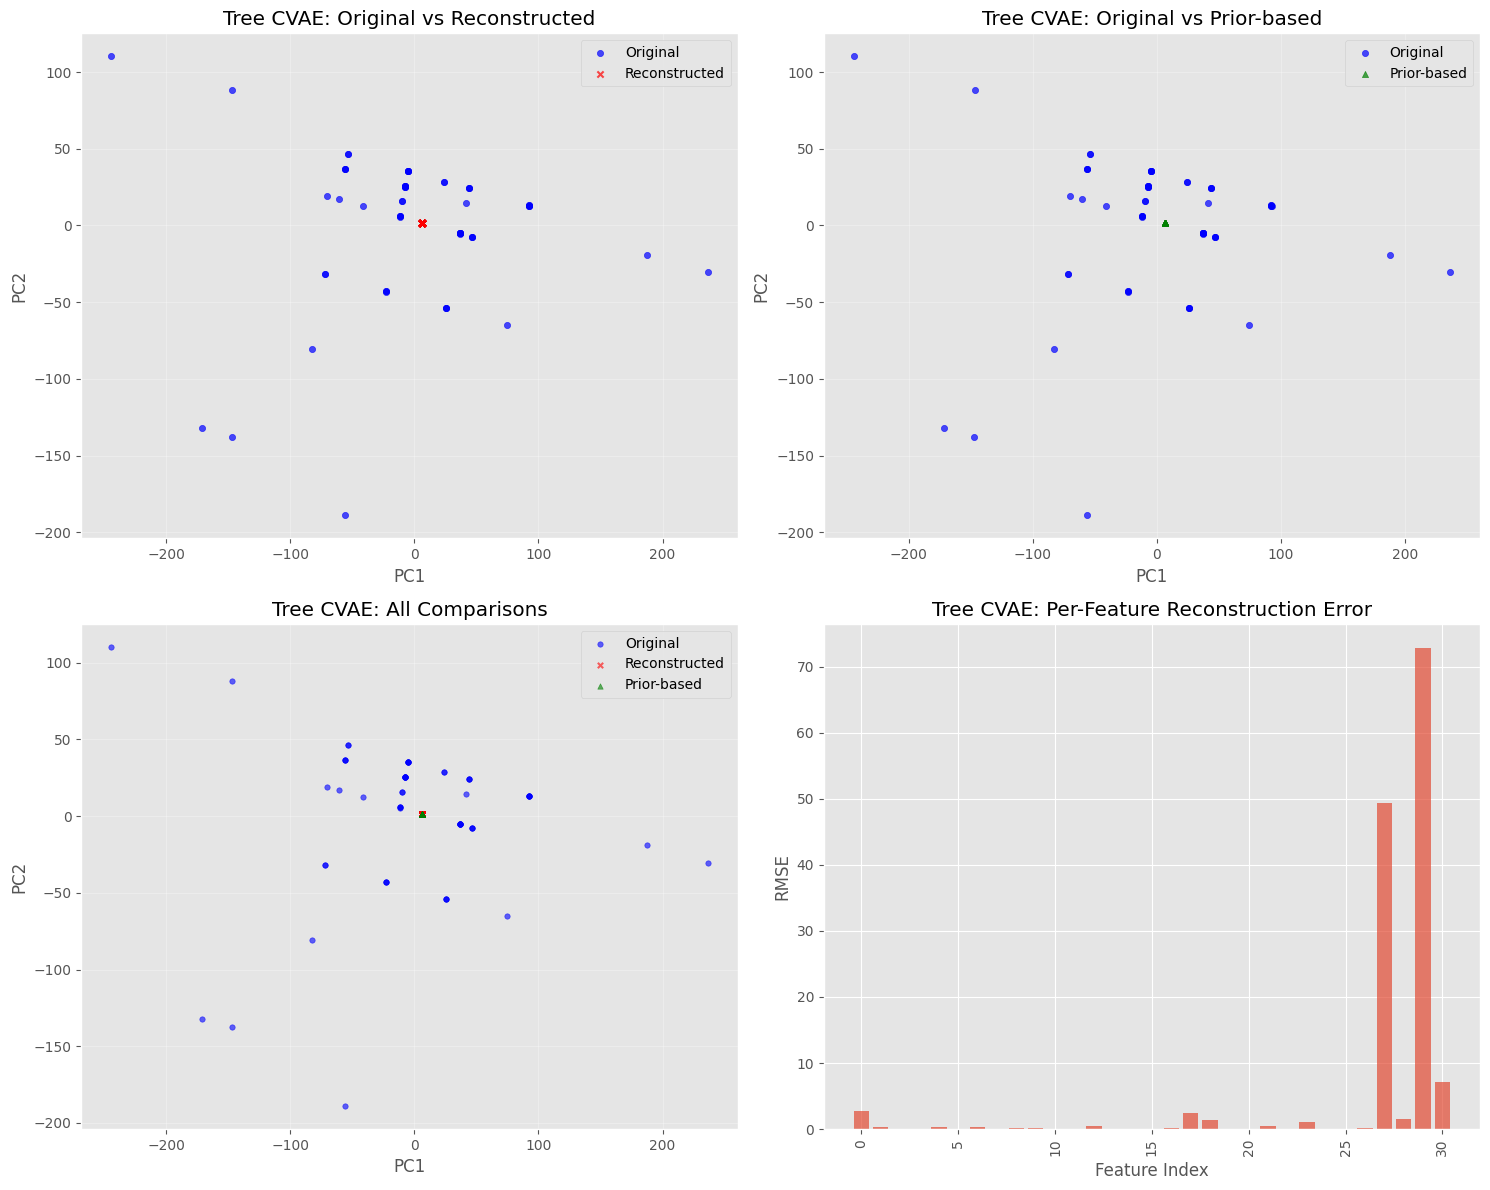


=== Tree CVAE Performance Summary ===
Original data mean: 66.5793
Reconstructed data mean: 66.7746
Prior-based data mean: 66.7746
Overall reconstruction RMSE: 15.8670
Overall prior-based RMSE: 15.8670

=== Model Comparison ===
Tree CVAE Test RRMSE: 0.2524
Original CVAE Test RRMSE: 0.2525
Tree CVAE improvement: 0.03%


In [37]:
# Visualize Tree CVAE performance: Original vs Reconstructed vs Prior-based Reconstruction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get a batch for evaluation
tree_model.eval()
xb_tree, yb_tree = next(iter(test_loader))

with torch.no_grad():
    # Original reconstruction (using encoder)
    xr_tree, mean_tree, logvar_tree = tree_model(xb_tree, yb_tree)
    
    # Prior-based reconstruction (sampling from N(0,1))
    z_prior_tree = torch.randn(xb_tree.size(0), latent_dim, device=device)
    xr_prior_tree = tree_model.dec(z_prior_tree, yb_tree)

# Convert to numpy for visualization
xb_tree_np = xb_tree.cpu().numpy()
xr_tree_np = xr_tree.cpu().numpy()
xr_prior_tree_np = xr_prior_tree.cpu().numpy()

# PCA analysis
pca_tree = PCA(n_components=2)
pca_tree.fit(xb_tree_np)

# Transform all three datasets
orig_tree_proj = pca_tree.transform(xb_tree_np)
recon_tree_proj = pca_tree.transform(xr_tree_np)
prior_tree_proj = pca_tree.transform(xr_prior_tree_np)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Original vs Reconstructed
axes[0, 0].scatter(orig_tree_proj[:, 0], orig_tree_proj[:, 1], 
                   label='Original', alpha=0.7, s=20, c='blue')
axes[0, 0].scatter(recon_tree_proj[:, 0], recon_tree_proj[:, 1], 
                   label='Reconstructed', alpha=0.7, s=20, c='red', marker='x')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].set_title('Tree CVAE: Original vs Reconstructed')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Original vs Prior-based
axes[0, 1].scatter(orig_tree_proj[:, 0], orig_tree_proj[:, 1], 
                   label='Original', alpha=0.7, s=20, c='blue')
axes[0, 1].scatter(prior_tree_proj[:, 0], prior_tree_proj[:, 1], 
                   label='Prior-based', alpha=0.7, s=20, c='green', marker='^')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
axes[0, 1].set_title('Tree CVAE: Original vs Prior-based')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: All three together
axes[1, 0].scatter(orig_tree_proj[:, 0], orig_tree_proj[:, 1], 
                   label='Original', alpha=0.6, s=15, c='blue')
axes[1, 0].scatter(recon_tree_proj[:, 0], recon_tree_proj[:, 1], 
                   label='Reconstructed', alpha=0.6, s=15, c='red', marker='x')
axes[1, 0].scatter(prior_tree_proj[:, 0], prior_tree_proj[:, 1], 
                   label='Prior-based', alpha=0.6, s=15, c='green', marker='^')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].set_title('Tree CVAE: All Comparisons')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Reconstruction error heatmap
recon_errors = np.sqrt(np.mean((xr_tree_np - xb_tree_np)**2, axis=0))
feature_names = X.columns[:len(recon_errors)]  # In case of dimension mismatch

im = axes[1, 1].bar(range(len(recon_errors)), recon_errors, alpha=0.7)
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Tree CVAE: Per-Feature Reconstruction Error')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Print quantitative comparison
orig_mean = np.mean(xb_tree_np, axis=0)
recon_mean = np.mean(xr_tree_np, axis=0)
prior_mean = np.mean(xr_prior_tree_np, axis=0)

print("\n=== Tree CVAE Performance Summary ===")
print(f"Original data mean: {np.mean(orig_mean):.4f}")
print(f"Reconstructed data mean: {np.mean(recon_mean):.4f}")
print(f"Prior-based data mean: {np.mean(prior_mean):.4f}")

overall_recon_rmse = np.sqrt(np.mean((xr_tree_np - xb_tree_np)**2))
overall_prior_rmse = np.sqrt(np.mean((xr_prior_tree_np - xb_tree_np)**2))

print(f"Overall reconstruction RMSE: {overall_recon_rmse:.4f}")
print(f"Overall prior-based RMSE: {overall_prior_rmse:.4f}")

# Compare with previous models
print(f"\n=== Model Comparison ===")
print(f"Tree CVAE Test RRMSE: {tree_rrmse_test:.4f}")
print(f"Original CVAE Test RRMSE: {rrmse_test:.4f}")
print(f"Tree CVAE improvement: {((rrmse_test - tree_rrmse_test) / rrmse_test * 100):.2f}%")

=== Top 10 Best Reconstructed Features ===
 1. Ag              | Corr: nan | RMSE: 0.010
 2. B               | Corr: nan | RMSE: 0.000
 3. Ca              | Corr: nan | RMSE: 0.001
 4. Cr              | Corr: 0.531 | RMSE: 0.097
 5. Co              | Corr: 0.259 | RMSE: 0.233
 6. Fe              | Corr: 0.050 | RMSE: 0.046
 7. Ce              | Corr: -0.181 | RMSE: 0.014
 8. Hf              | Corr: nan | RMSE: 0.000
 9. La              | Corr: nan | RMSE: 0.001
10. Mg              | Corr: 0.062 | RMSE: 0.412

=== Top 10 Worst Reconstructed Features ===
 1. Tag (K)         | Corr: 0.134 | RMSE: 565.202
 2. V               | Corr: 0.037 | RMSE: 0.031
 3. Al              | Corr: -0.059 | RMSE: 0.241
 4. Zr              | Corr: -0.094 | RMSE: 0.092
 5. tag (h)         | Corr: -0.099 | RMSE: 7.126
 6. Zn              | Corr: -0.118 | RMSE: 0.039
 7. Be              | Corr: -0.147 | RMSE: 0.289
 8. tss (h)         | Corr: -0.267 | RMSE: 1.552
 9. Si              | Corr: -0.293 | RMSE: 0.444


c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


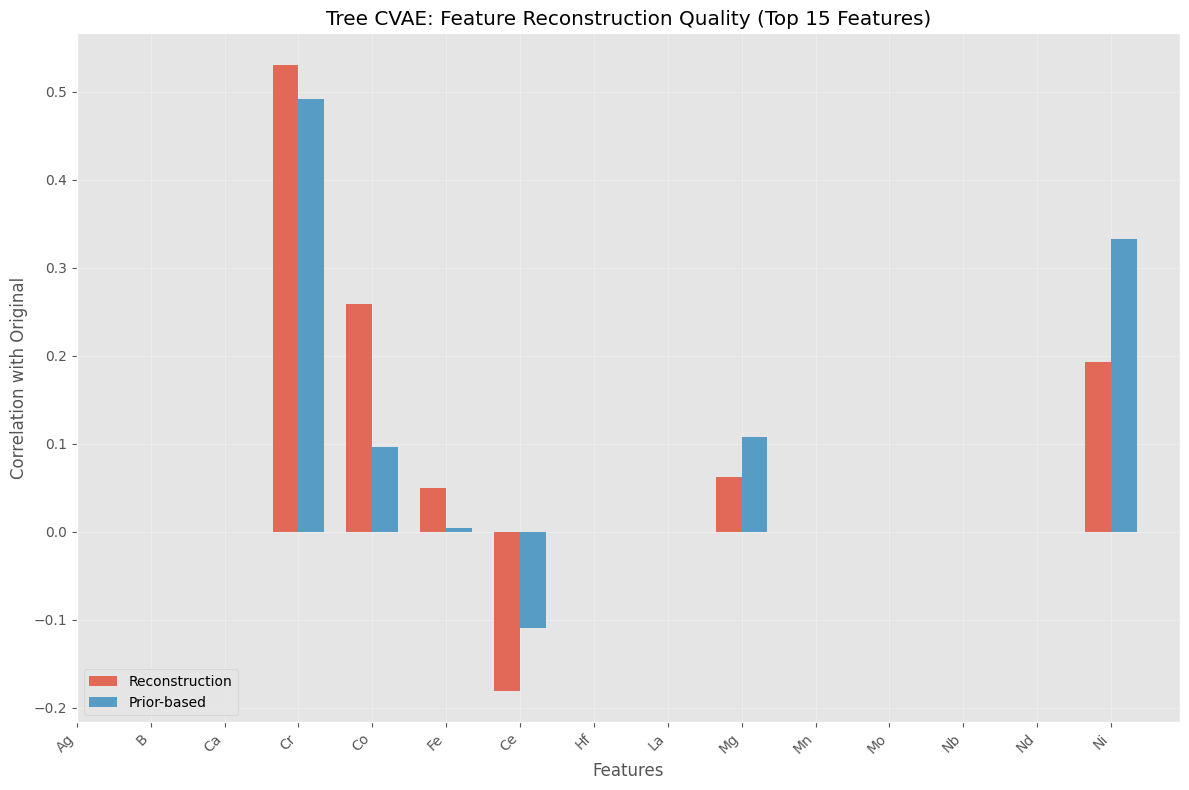

In [25]:
# Detailed feature-wise analysis for Tree CVAE
# Compute per-feature statistics
feature_stats = []
for i, feature_name in enumerate(X.columns):
    if i < xr_tree_np.shape[1]:  # Ensure we don't go out of bounds
        orig_vals = xb_tree_np[:, i]
        recon_vals = xr_tree_np[:, i]
        prior_vals = xr_prior_tree_np[:, i]
        
        recon_corr = np.corrcoef(orig_vals, recon_vals)[0, 1]
        prior_corr = np.corrcoef(orig_vals, prior_vals)[0, 1]
        
        recon_rmse = np.sqrt(np.mean((recon_vals - orig_vals)**2))
        prior_rmse = np.sqrt(np.mean((prior_vals - orig_vals)**2))
        
        feature_stats.append({
            'feature': feature_name,
            'recon_corr': recon_corr,
            'prior_corr': prior_corr,
            'recon_rmse': recon_rmse,
            'prior_rmse': prior_rmse
        })

# Sort by reconstruction correlation (best features first)
feature_stats.sort(key=lambda x: x['recon_corr'], reverse=True)

print("=== Top 10 Best Reconstructed Features ===")
for i, stat in enumerate(feature_stats[:10]):
    print(f"{i+1:2d}. {stat['feature']:15s} | Corr: {stat['recon_corr']:.3f} | RMSE: {stat['recon_rmse']:.3f}")

print("\n=== Top 10 Worst Reconstructed Features ===")
for i, stat in enumerate(feature_stats[-10:]):
    print(f"{i+1:2d}. {stat['feature']:15s} | Corr: {stat['recon_corr']:.3f} | RMSE: {stat['recon_rmse']:.3f}")

# Visualization of feature correlation comparison
best_features = [stat['feature'] for stat in feature_stats[:15]]
recon_corrs = [stat['recon_corr'] for stat in feature_stats[:15]]
prior_corrs = [stat['prior_corr'] for stat in feature_stats[:15]]

plt.figure(figsize=(12, 8))
x_pos = np.arange(len(best_features))
width = 0.35

plt.bar(x_pos - width/2, recon_corrs, width, label='Reconstruction', alpha=0.8)
plt.bar(x_pos + width/2, prior_corrs, width, label='Prior-based', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Correlation with Original')
plt.title('Tree CVAE: Feature Reconstruction Quality (Top 15 Features)')
plt.xticks(x_pos, best_features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()